In [27]:
import torch

import matplotlib.pyplot as plt

import numpy as np
import os, sys
import datetime as dt

import networks

sys.path.append('/nobackupp10/tvandal/wildfire/')
from wildfire.goes import utilities, scan
from wildfire import wildfire

## Load PyTorch Model for Classifying Wildfires

In [2]:
# Load model
checkpoint_file = '/nobackupp10/tvandal/wildfire/.tmp/models/first_model/checkpoint.torch'
model = networks.BasicCNNClassifier(16)
checkpoint = torch.load(checkpoint_file)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

## Get Data for a Given Satellite and Time

In [178]:
satellite = 'noaa-goes16'
region = 'C'
#start_scan_time = '2019-10-31T21:00:00'
#goes_directory = '/nobackupp10/tvandal/wildfire/downloaded_data/'
start_scan_time = '2018-11-10T20:00:00'
goes_directory = '/nex/datapool/geonex/public/GOES16/NOAA-L1B/'

DATETIME_FORMAT = "%Y-%m-%dT%H:%M:%S"
start_time = dt.datetime.strptime(start_scan_time, DATETIME_FORMAT)
end_time = start_time + dt.timedelta(minutes=15)

filepaths = utilities.list_local_files(local_directory=goes_directory,
                                       satellite=satellite,
                                       region=region,
                                       start_time=start_time,
                                       end_time=end_time)

filepaths = utilities.group_filepaths_into_scans(filepaths=filepaths)

glob: 100%|██████████| 1/1 [00:00<00:00, 312.84it/s]


In [179]:
goes_scan = scan.read_netcdfs(local_filepaths=filepaths[0])
print(filepaths[0])

['/nex/datapool/geonex/public/GOES16/NOAA-L1B//ABI-L1b-RadC/2018/314/20/OR_ABI-L1b-RadC-M3C15_G16_s20183142002177_e20183142004556_c20183142004596.nc', '/nex/datapool/geonex/public/GOES16/NOAA-L1B//ABI-L1b-RadC/2018/314/20/OR_ABI-L1b-RadC-M3C12_G16_s20183142002177_e20183142004556_c20183142005003.nc', '/nex/datapool/geonex/public/GOES16/NOAA-L1B//ABI-L1b-RadC/2018/314/20/OR_ABI-L1b-RadC-M3C09_G16_s20183142002177_e20183142004556_c20183142004593.nc', '/nex/datapool/geonex/public/GOES16/NOAA-L1B//ABI-L1b-RadC/2018/314/20/OR_ABI-L1b-RadC-M3C16_G16_s20183142002177_e20183142004562_c20183142005002.nc', '/nex/datapool/geonex/public/GOES16/NOAA-L1B//ABI-L1b-RadC/2018/314/20/OR_ABI-L1b-RadC-M3C03_G16_s20183142002177_e20183142004550_c20183142004595.nc', '/nex/datapool/geonex/public/GOES16/NOAA-L1B//ABI-L1b-RadC/2018/314/20/OR_ABI-L1b-RadC-M3C14_G16_s20183142002177_e20183142004550_c20183142004593.nc', '/nex/datapool/geonex/public/GOES16/NOAA-L1B//ABI-L1b-RadC/2018/314/20/OR_ABI-L1b-RadC-M3C06_G16_s2

## Show a False Color RGB Image

In [180]:
scan_data = [g.rescale_to_500m().normalize().values[:,:,np.newaxis] for _, g in goes_scan.iteritems()]
scan_data = np.concatenate(scan_data, 2)
scan_data = np.transpose(scan_data, (2,0,1))[np.newaxis]
scan_data[np.isnan(scan_data)] = 0.
print('Scan Data Shape: {}'.format(scan_data.shape))

Scan Data Shape: (1, 16, 1500, 2500)


(-0.5, 599.5, 599.5, -0.5)

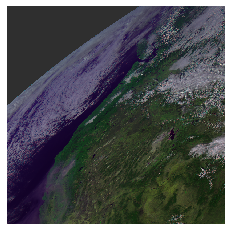

In [188]:
rgb_scan = scan_data[0,[1,2,0],:600,:600]
mx = np.max(rgb_scan)
mn = np.min(rgb_scan)
plt.imshow(np.transpose((rgb_scan-mn)/(mx-mn), (1,2,0)))
plt.axis('off')

## Band 7 - Hot Spot

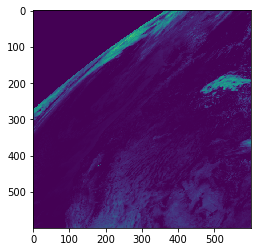

In [189]:
plt.imshow(scan_data[0,6,:600,:600]**2)
plt.show()

## Wildfires as Classified from a Threshold Model

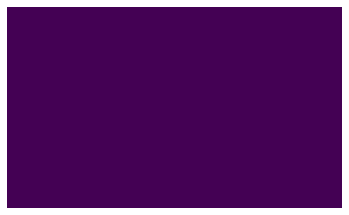

In [190]:
imap = wildfire.predict_wildfires_goes(goes_scan)
plt.imshow(imap.astype(float), vmin=0, vmax=1.)
plt.axis('off')
plt.show()

## Predict with CNN Classifier

(-0.5, 2499.5, 1499.5, -0.5)

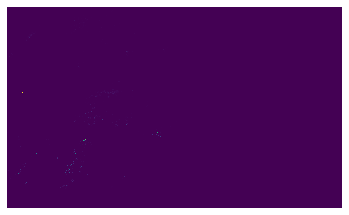

In [191]:
cnn_prediction = model(torch.tensor(scan_data).float()).detach().numpy()

plt.imshow(cnn_prediction[0,0], vmin=0, vmax=1)
plt.axis('off')